# Survival analysis of Titanic training dataset

## Summary of  findings
There are three types of peoples in the world. One who does not believe in any form of flattery and the other, who considers flattery to be the biggest excitement in the world.

## Setup code

In [4]:
import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Data exploration and cleanup

### Making sense of the data

In [2]:
train = pd.read_csv("train.csv")
print "the variable train is of data type ", type (train)
print
print (train.head(5))

the variable train is of data type  <class 'pandas.core.frame.DataFrame'>

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex  Age  SibSp  \
0                            Braund, Mr. Owen Harris    male   22      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female   38      1   
2                             Heikkinen, Miss. Laina  female   26      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   35      1   
4                           Allen, Mr. William Henry    male   35      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C1

In [4]:
print (train.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


Observations - 
1. Age has only 714 values. Also pretty young crowd in the Titanic with 75% of people less than 38.
2. Only 38.38% survival
3. More than 50% people were in the 3rd class
4. Most people don't have any parents or children - 75% have 0
5. Some people freeloaded into the Titanic i.e. 0 fare, while 75% have paid \$31 or less. So the max number \$512 is clearly an outlier or a mistake.

In [6]:
# Some more detailed stats.
print train['Age'].median()
print
print train['Embarked'].unique()
print
train['Sex'].unique()

28.0

['S' 'C' 'Q' nan]



array(['male', 'female'], dtype=object)

(array([  54.,   46.,  177.,  169.,  118.,   70.,   45.,   24.,    9.,    2.]),
 array([  0.42 ,   8.378,  16.336,  24.294,  32.252,  40.21 ,  48.168,
         56.126,  64.084,  72.042,  80.   ]),
 <a list of 10 Patch objects>)

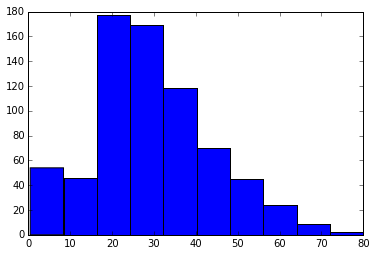

In [5]:
# age distribution
plt.hist(train['Age'],bins=10,range = (train['Age'].min(),train['Age'].max()))

most of the people seem to be young adults.

(array([ 562.,  170.,   67.,   39.,   15.,   16.,    2.,    0.,    9.,
           2.,    6.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    3.]),
 array([   0.     ,   25.61646,   51.23292,   76.84938,  102.46584,
         128.0823 ,  153.69876,  179.31522,  204.93168,  230.54814,
         256.1646 ,  281.78106,  307.39752,  333.01398,  358.63044,
         384.2469 ,  409.86336,  435.47982,  461.09628,  486.71274,
         512.3292 ]),
 <a list of 20 Patch objects>)

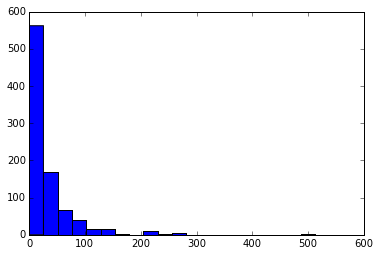

In [9]:
plt.hist(train['Fare'],bins=20)

seems like most of the fares are less than 100. but there are a few outliers that are pretty expensive. worth splitting the fares up by 100 and looking at the fare distribution.

### Data cleanup
I noticed some NaN in the cabin. Age seems to have a few nulls as well. Factors such as SibSp etc. are being considered as numbers. Gotta clean all this up!

##Exploratory analysis to get some intuition
Some intuition around the topic of Titanic (mostly through the movie and some reading)

Hypotheses to be tested
- Women and children first!
- First class passengers survived more than third class
- Number of siblings and parents contributed 
    - Adults with spouses or siblings survived more by virtue of helping each other
    - Children with parents survived more than those without parents
    - Converse to point 2, parents with children would have sacrificed and probably had lower survival rates (just a bit)
- Where people embarked contributed to survival

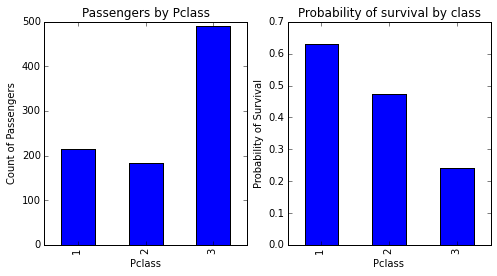

In [6]:

temp1 = train.groupby('Pclass').Survived.count()
temp2 = train.groupby('Pclass').Survived.sum()/train.groupby('Pclass').Survived.count()

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Pclass')
ax1.set_ylabel('Count of Passengers')
ax1.set_title("Passengers by Pclass")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)
temp2.plot(kind = 'bar')
ax2.set_xlabel('Pclass')
ax2.set_ylabel('Probability of Survival')
ax2.set_title("Probability of survival by class")

## Predicting survival